In [1]:
import os
import pathlib
import random
import functools
import copy
import sys
import pickle
import tarfile
import operator
import math
import requests
import importlib

import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sklearn
from sklearn import preprocessing
import scipy

import tensorflow as tf
import tensorflow_datasets as tfds


from tensorflow import keras
from tensorflow.keras import layers

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import flax

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

import neural_tangents as nt

import vit_jax

import adversarial_ntks as atk

[0 1 0 1 1 0 1 1 0 0]


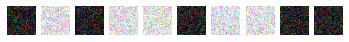

[1 0 0 1 0 0 1 1 1 0]


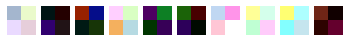

In [2]:
def generate_image_data(image_shape, m1, s1, m2, s2, num_samples):
    assert num_samples % 2 == 0
    
    xs = np.concatenate([
        np.random.normal(loc=m1, scale=s1, size=(num_samples // 2,) + image_shape),
        np.random.normal(loc=m2, scale=s2, size=(num_samples // 2,) + image_shape)
    ]).clip(0, 1)
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

def plot_images(xs, flat=True, channels=1):
    for i, x in enumerate(xs):
        plt.subplot(1, len(xs), i + 1)
        plt.imshow(x, cmap="Greys", vmin=0, vmax=1)
        plt.axis("off")
    plt.show()

x_tmp, y_tmp = generate_image_data(
    image_shape=(32, 32, 3),
    m1=0.1, s1=0.2,
    m2=0.9, s2=0.2,
    num_samples=10
)
print(y_tmp)
plot_images(x_tmp)

x_tmp, y_tmp = generate_image_data(
    image_shape=(2, 2, 3),
    m1=0.1, s1=0.2,
    m2=0.9, s2=0.2,
    num_samples=10
)
print(y_tmp)
plot_images(x_tmp)

[1 1 0 0 0 0 1 0 1 1]


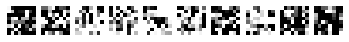

In [3]:
x_tmp, y_tmp = generate_image_data(
    image_shape=(8, 8, 1),
    m1=0.1, s1=1,
    m2=0.9, s2=1,
    num_samples=10
)
print(y_tmp)
plot_images(x_tmp)

In [4]:
def run_experiment(
    image_shape,
    m1, s1,
    m2, s2,
    get_model,
    from_logits,
    train_epochs,
    attack_norm,
    attack_eps,
    attack_eps_step,
    attack_iters,
    train_batch_size=64,
    attack_batch_size=256,
    num_train=10 ** 4,
    num_test=2000,
    seed=42
):
    """
    Default values for num_train and num_test are size of CIFAR10 dataset.
    
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    x_train, y_train = generate_image_data(
        image_shape=image_shape,
        m1=m1, s1=s1,
        m2=m2, s2=s2,
        num_samples=num_train,
    )

    x_test, y_test = generate_image_data(
        image_shape=image_shape,
        m1=m1, s1=s1,
        m2=m2, s2=s2,
        num_samples=num_test,
    )
    
    model = get_model(x_train[0].shape)
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.fit(
        x_train,
        y_train,
        batch_size=train_batch_size,
        epochs=train_epochs,
        validation_data=(x_test, y_test),
        verbose=1,
    )
    model.trainable = False
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        loss_object=keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
        clip_values=[x_test.min(), x_test.max()],
    )
    art_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=attack_batch_size,
    )
    
    x_train_adv = art_attack.generate(x_train[:num_test], y=y_train[:num_test])    
    x_test_adv = art_attack.generate(x_test, y=y_test)
    
    _, nat_train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, nat_test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, adv_train_acc = model.evaluate(x_train_adv, y_train[:num_test], verbose=0)
    _, adv_test_acc = model.evaluate(x_test_adv, y_test, verbose=0)
    
    print("Nat train acc :", nat_train_acc)
    print("Nat test  acc :", nat_test_acc)
    print("Adv train acc :", adv_train_acc)
    print("Adv test  acc :", adv_test_acc)
    
    return dict(
        model=model,
        train_data=(x_train, y_train),
        test_data=(x_test, y_test),
        x_train_adv=x_train_adv,
        x_test_adv=x_test_adv,
    )

In [5]:
%%time
res = run_experiment(
    image_shape=(32, 32, 3),
    m1=0.1, s1=0.2,
    m2=0.9, s2=0.2,
    get_model=lambda input_shape: keras.applications.EfficientNetB0(
        weights=None,
        input_shape=input_shape,
        classes=2,
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=2,
    attack_eps_step=0.2,
    attack_iters=20,
)

Epoch 1/5
157/157 [==============================] - 42s 176ms/step - loss: 1.7951 - accuracy: 0.8801 - val_loss: 1.1900 - val_accuracy: 0.5000
Epoch 2/5
157/157 [==============================] - 22s 142ms/step - loss: 0.0530 - accuracy: 0.9953 - val_loss: 3.4664 - val_accuracy: 0.5000
Epoch 3/5
157/157 [==============================] - 22s 142ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.4884 - val_accuracy: 0.5725
Epoch 4/5
157/157 [==============================] - 23s 145ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0697 - val_accuracy: 0.9760
Epoch 5/5
157/157 [==============================] - 22s 142ms/step - loss: 0.0510 - accuracy: 0.9950 - val_loss: 0.0017 - val_accuracy: 0.9990
Nat train acc : 0.9995999932289124
Nat test  acc : 0.9990000128746033
Adv train acc : 0.9039999842643738
Adv test  acc : 0.906499981880188
Wall time: 3min 57s


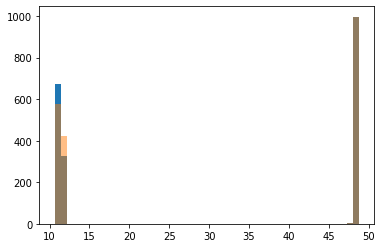

In [6]:
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=50)
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5)
plt.show()

In [7]:
%%time
res = run_experiment(
    image_shape=(8, 8, 3),
    m1=0.1, s1=1,
    m2=0.9, s2=1,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=2,
    attack_eps_step=0.2,
    attack_iters=20,
)

Epoch 1/5
157/157 [==============================] - 2s 8ms/step - loss: 0.6659 - accuracy: 0.6098 - val_loss: 0.3132 - val_accuracy: 0.9635
Epoch 2/5
157/157 [==============================] - 1s 6ms/step - loss: 0.2183 - accuracy: 0.9795 - val_loss: 0.0655 - val_accuracy: 0.9985
Epoch 3/5
157/157 [==============================] - 1s 6ms/step - loss: 0.0538 - accuracy: 0.9991 - val_loss: 0.0262 - val_accuracy: 0.9990
Epoch 4/5
157/157 [==============================] - 1s 6ms/step - loss: 0.0230 - accuracy: 0.9999 - val_loss: 0.0147 - val_accuracy: 0.9995
Epoch 5/5
157/157 [==============================] - 1s 6ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 0.9995
Nat train acc : 1.0
Nat test  acc : 0.9994999766349792
Adv train acc : 0.09749999642372131
Adv test  acc : 0.09950000047683716
Wall time: 11.2 s


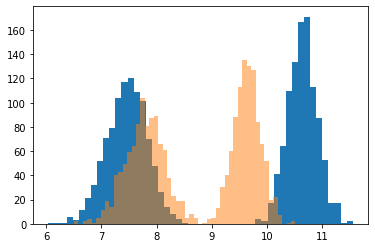

In [8]:
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=50)
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5)
plt.show()

In [9]:
%%time
res = run_experiment(
    image_shape=(32, 32, 3),
    m1=0.1, s1=1,
    m2=0.9, s2=1,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=2,
    attack_eps_step=0.2,
    attack_iters=20,
)

Epoch 1/5
157/157 [==============================] - 2s 9ms/step - loss: 0.2213 - accuracy: 0.9107 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 2/5
157/157 [==============================] - 1s 8ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 5.3143e-04 - val_accuracy: 1.0000
Epoch 3/5
157/157 [==============================] - 1s 8ms/step - loss: 4.3888e-04 - accuracy: 1.0000 - val_loss: 2.6556e-04 - val_accuracy: 1.0000
Epoch 4/5
157/157 [==============================] - 1s 8ms/step - loss: 2.2942e-04 - accuracy: 1.0000 - val_loss: 1.6094e-04 - val_accuracy: 1.0000
Epoch 5/5
157/157 [==============================] - 1s 7ms/step - loss: 1.4118e-04 - accuracy: 1.0000 - val_loss: 1.0698e-04 - val_accuracy: 1.0000
Nat train acc : 1.0
Nat test  acc : 1.0
Adv train acc : 1.0
Adv test  acc : 1.0
Wall time: 17.2 s


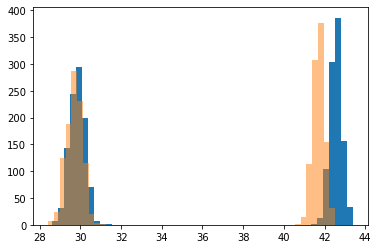

In [10]:
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=50)
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5)
plt.show()

Epoch 1/5
157/157 [==============================] - 2s 8ms/step - loss: 0.5357 - accuracy: 0.6816 - val_loss: 0.2657 - val_accuracy: 0.9980
Epoch 2/5
157/157 [==============================] - 1s 6ms/step - loss: 0.2059 - accuracy: 0.9995 - val_loss: 0.0932 - val_accuracy: 1.0000
Epoch 3/5
157/157 [==============================] - 1s 6ms/step - loss: 0.0748 - accuracy: 1.0000 - val_loss: 0.0406 - val_accuracy: 1.0000
Epoch 4/5
157/157 [==============================] - 1s 6ms/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 1.0000
Epoch 5/5
157/157 [==============================] - 1s 6ms/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 0.0134 - val_accuracy: 1.0000
Nat train acc : 1.0
Nat test  acc : 1.0
Adv train acc : 0.0
Adv test  acc : 0.0


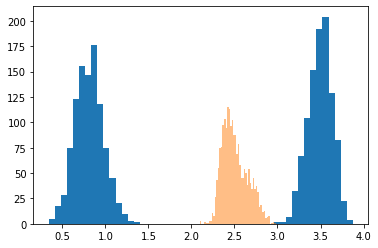

Wall time: 22.3 s


In [11]:
%%time
res = run_experiment(
    image_shape=(4, 4, 1),
    m1=0.1, s1=0.2,
    m2=0.9, s2=0.2,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(16, kernel_size=(2, 2), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=4,
    attack_eps_step=0.05,
    attack_iters=80,
)
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=50)
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5)
plt.show()

Epoch 1/5
157/157 [==============================] - 2s 8ms/step - loss: 0.5233 - accuracy: 0.6790 - val_loss: 0.3076 - val_accuracy: 0.9920
Epoch 2/5
157/157 [==============================] - 1s 6ms/step - loss: 0.2543 - accuracy: 0.9961 - val_loss: 0.1343 - val_accuracy: 0.9990
Epoch 3/5
157/157 [==============================] - 1s 7ms/step - loss: 0.1108 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 1.0000
Epoch 4/5
157/157 [==============================] - 1s 6ms/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 0.0370 - val_accuracy: 1.0000
Epoch 5/5
157/157 [==============================] - 1s 6ms/step - loss: 0.0325 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 1.0000
Nat train acc : 1.0
Nat test  acc : 1.0
Adv train acc : 0.0
Adv test  acc : 0.0


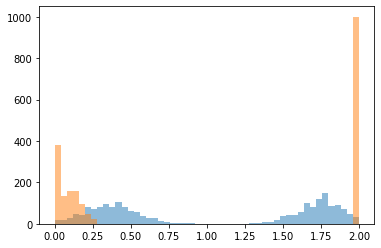

Wall time: 13.8 s


In [12]:
%%time
res = run_experiment(
    image_shape=(2, 2, 1),
    m1=0.1, s1=0.2,
    m2=0.9, s2=0.2,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(8, activation="relu"),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=4,
    attack_eps_step=0.1,
    attack_iters=40,
)
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5, label="test")
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5, label="adversarial")
plt.show()

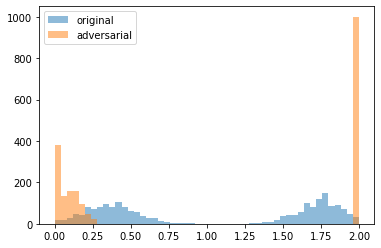

In [14]:
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5, label="original")
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5, label="adversarial")
plt.legend()
plt.show()

Epoch 1/5
157/157 [==============================] - 1s 7ms/step - loss: 0.5640 - accuracy: 0.5934 - val_loss: 0.3705 - val_accuracy: 0.9640
Epoch 2/5
157/157 [==============================] - 1s 5ms/step - loss: 0.3164 - accuracy: 0.9775 - val_loss: 0.1853 - val_accuracy: 0.9940
Epoch 3/5
157/157 [==============================] - 1s 5ms/step - loss: 0.1575 - accuracy: 0.9960 - val_loss: 0.0999 - val_accuracy: 0.9965
Epoch 4/5
157/157 [==============================] - 1s 5ms/step - loss: 0.0891 - accuracy: 0.9977 - val_loss: 0.0618 - val_accuracy: 0.9975
Epoch 5/5
157/157 [==============================] - 1s 6ms/step - loss: 0.0552 - accuracy: 0.9987 - val_loss: 0.0424 - val_accuracy: 0.9980
Nat train acc : 0.9990000128746033
Nat test  acc : 0.9980000257492065
Adv train acc : 0.6355000138282776
Adv test  acc : 0.6549999713897705


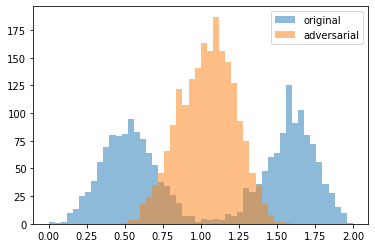

Wall time: 13.8 s


In [23]:
%%time
res = run_experiment(
    image_shape=(2, 2, 1),
    m1=0.1, s1=0.2,
    m2=0.9, s2=0.2,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(8, activation="relu"),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=0.5,
    attack_eps_step=0.1,
    attack_iters=40,
)
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5, label="original", range=(0,2))
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5, label="adversarial", range=(0,2))
plt.legend()
plt.show()

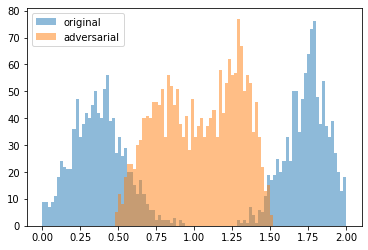

In [17]:
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="original", range=(0,2))
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="adversarial", range=(0,2))
plt.legend()
plt.show()

In [20]:
%%time
res = run_experiment(
    image_shape=(2, 2, 1),
    m1=0.1, s1=0.2,
    m2=0.9, s2=0.2,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(8, activation="relu"),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=0.5,
    attack_eps_step=0.1,
    attack_iters=40,
)
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=inf, axis=-1), bins=100, alpha=0.5, label="original", range=(0,2))
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="adversarial", range=(0,2))
plt.legend()
plt.show()

Epoch 1/5
157/157 [==============================] - 1s 7ms/step - loss: 0.5233 - accuracy: 0.6790 - val_loss: 0.3076 - val_accuracy: 0.9920
Epoch 2/5
157/157 [==============================] - 1s 5ms/step - loss: 0.2543 - accuracy: 0.9961 - val_loss: 0.1343 - val_accuracy: 0.9990
Epoch 3/5
157/157 [==============================] - 1s 6ms/step - loss: 0.1108 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 1.0000
Epoch 4/5
157/157 [==============================] - 1s 5ms/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 0.0370 - val_accuracy: 1.0000
Epoch 5/5
157/157 [==============================] - 1s 5ms/step - loss: 0.0325 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 1.0000
Nat train acc : 1.0
Nat test  acc : 1.0
Adv train acc : 0.8930000066757202
Adv test  acc : 0.9045000076293945


NameError: name 'inf' is not defined

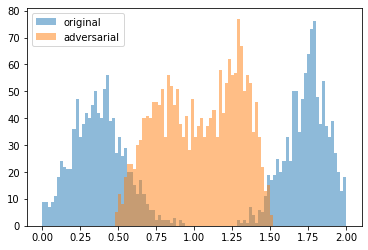

In [22]:
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="original", range=(0,2))
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="adversarial", range=(0,2))
plt.legend()
plt.show()

Epoch 1/5
157/157 [==============================] - 1s 7ms/step - loss: 0.5640 - accuracy: 0.5934 - val_loss: 0.3705 - val_accuracy: 0.9640
Epoch 2/5
157/157 [==============================] - 1s 5ms/step - loss: 0.3164 - accuracy: 0.9775 - val_loss: 0.1853 - val_accuracy: 0.9940
Epoch 3/5
157/157 [==============================] - 1s 5ms/step - loss: 0.1575 - accuracy: 0.9960 - val_loss: 0.0999 - val_accuracy: 0.9965
Epoch 4/5
157/157 [==============================] - 1s 5ms/step - loss: 0.0891 - accuracy: 0.9977 - val_loss: 0.0618 - val_accuracy: 0.9975
Epoch 5/5
157/157 [==============================] - 1s 5ms/step - loss: 0.0552 - accuracy: 0.9987 - val_loss: 0.0424 - val_accuracy: 0.9980
Nat train acc : 0.9990000128746033
Nat test  acc : 0.9980000257492065
Adv train acc : 0.6355000138282776
Adv test  acc : 0.6549999713897705


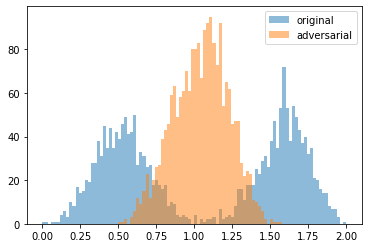

Wall time: 12.6 s


In [25]:
%%time
res = run_experiment(
    image_shape=(2, 2, 1),
    m1=0.2, s1=0.2,
    m2=0.8, s2=0.2,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(8, activation="relu"),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=0.5,
    attack_eps_step=0.1,
    attack_iters=40,
)
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="original", range=(0,2))
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="adversarial", range=(0,2))
plt.legend()
plt.show()

(1000, 2, 2, 1) (1000, 2, 2, 1)


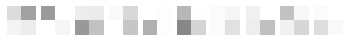

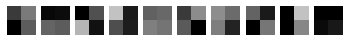

(1000, 2, 2, 1) (1000, 2, 2, 1)


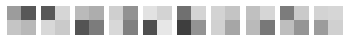

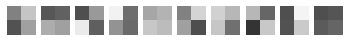

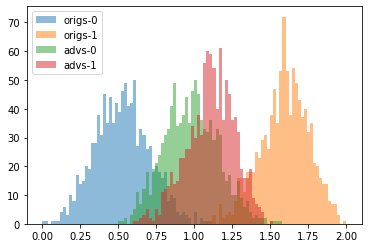

In [50]:
count = res["x_test_adv"].shape[0]
origs = (np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(origs[0].shape, origs[1].shape)
plot_images(origs[0][:10])
plot_images(origs[1][:10])
advs = (np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(advs[0].shape, advs[1].shape)
plot_images(advs[0][:10])
plot_images(advs[1][:10])

####

plt.hist(np.linalg.norm(origs[0].reshape((origs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-0", range=(0,2))
plt.hist(np.linalg.norm(origs[1].reshape((origs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-1", range=(0,2))
plt.hist(np.linalg.norm(advs[0].reshape((advs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-0", range=(0,2))
plt.hist(np.linalg.norm(advs[1].reshape((advs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-1", range=(0,2))
plt.legend()
plt.show()

Epoch 1/5
157/157 [==============================] - 1s 7ms/step - loss: 0.5233 - accuracy: 0.6790 - val_loss: 0.3076 - val_accuracy: 0.9920
Epoch 2/5
157/157 [==============================] - 1s 5ms/step - loss: 0.2543 - accuracy: 0.9961 - val_loss: 0.1343 - val_accuracy: 0.9990
Epoch 3/5
157/157 [==============================] - 1s 5ms/step - loss: 0.1108 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 1.0000
Epoch 4/5
157/157 [==============================] - 1s 5ms/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 0.0370 - val_accuracy: 1.0000
Epoch 5/5
157/157 [==============================] - 1s 5ms/step - loss: 0.0325 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 1.0000
Nat train acc : 1.0
Nat test  acc : 1.0
Adv train acc : 0.0
Adv test  acc : 0.0
(1000, 2, 2, 1) (1000, 2, 2, 1)


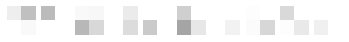

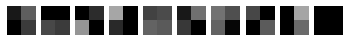

(1000, 2, 2, 1) (1000, 2, 2, 1)


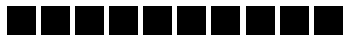

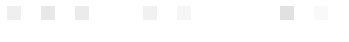

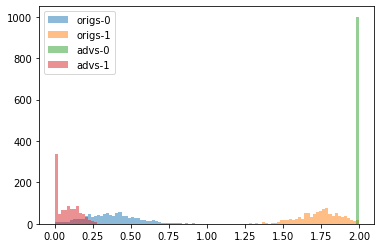

Wall time: 15.6 s


In [52]:
%%time
res = run_experiment(
    image_shape=(2, 2, 1),
    m1=0.1, s1=0.2,
    m2=0.9, s2=0.2,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(8, activation="relu"),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=2,
    attack_eps_step=0.1,
    attack_iters=40,
)

count = res["x_test_adv"].shape[0]
origs = (np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(origs[0].shape, origs[1].shape)
plot_images(origs[0][:10])
plot_images(origs[1][:10])
advs = (np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(advs[0].shape, advs[1].shape)
plot_images(advs[0][:10])
plot_images(advs[1][:10])

####

plt.hist(np.linalg.norm(origs[0].reshape((origs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-0", range=(0,2))
plt.hist(np.linalg.norm(origs[1].reshape((origs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-1", range=(0,2))
plt.hist(np.linalg.norm(advs[0].reshape((advs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-0", range=(0,2))
plt.hist(np.linalg.norm(advs[1].reshape((advs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-1", range=(0,2))
plt.legend()
plt.show()

Epoch 1/5
157/157 [==============================] - 1s 7ms/step - loss: 0.5458 - accuracy: 0.5518 - val_loss: 0.4446 - val_accuracy: 0.5940
Epoch 2/5
157/157 [==============================] - 1s 5ms/step - loss: 0.4034 - accuracy: 0.8107 - val_loss: 0.3268 - val_accuracy: 0.9785
Epoch 3/5
157/157 [==============================] - 1s 5ms/step - loss: 0.2925 - accuracy: 0.9641 - val_loss: 0.2374 - val_accuracy: 0.9935
Epoch 4/5
157/157 [==============================] - 1s 5ms/step - loss: 0.1927 - accuracy: 0.9992 - val_loss: 0.1648 - val_accuracy: 1.0000
Epoch 5/5
157/157 [==============================] - 1s 5ms/step - loss: 0.1339 - accuracy: 0.9998 - val_loss: 0.1150 - val_accuracy: 1.0000
Nat train acc : 1.0
Nat test  acc : 1.0
Adv train acc : 0.0
Adv test  acc : 0.0
(1000, 32, 32, 3) (1000, 32, 32, 3)


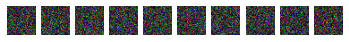

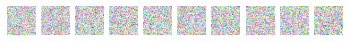

(1000, 32, 32, 3) (1000, 32, 32, 3)


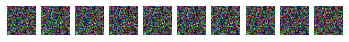

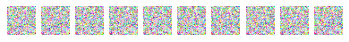

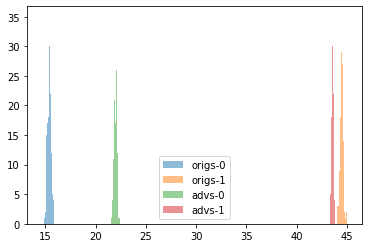

Max perturb norm: 16.0
Wall time: 18.9 s


In [54]:
%%time
IMG_DIM = 32
IMG_CHANNELS = 3
NORM_RANGE_MAX = IMG_DIM * IMG_CHANNELS ** 0.5
ATTACK_EPS = NORM_RANGE_MAX / 2
ATTACK_EPS_STEP = 0.4
ATTACK_ITERS = 40

res = run_experiment(
    image_shape=(IMG_DIM, IMG_DIM, IMG_CHANNELS),
    m1=0.2, s1=0.2,
    m2=0.8, s2=0.2,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(16, activation="relu"),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=ATTACK_EPS,
    attack_eps_step=ATTACK_EPS_STEP,
    attack_iters=ATTACK_ITERS,
)

count = res["x_test_adv"].shape[0]
origs = (np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(origs[0].shape, origs[1].shape)
plot_images(origs[0][:10])
plot_images(origs[1][:10])
advs = (np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(advs[0].shape, advs[1].shape)
plot_images(advs[0][:10])
plot_images(advs[1][:10])

####

plt.hist(np.linalg.norm(origs[0].reshape((origs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-0")
plt.hist(np.linalg.norm(origs[1].reshape((origs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-1")
plt.hist(np.linalg.norm(advs[0].reshape((advs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-0")
plt.hist(np.linalg.norm(advs[1].reshape((advs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-1")
plt.legend()
plt.show()

print("Max perturb norm:", min(ATTACK_EPS, ATTACK_EPS_STEP * ATTACK_ITERS))

Epoch 1/5
157/157 [==============================] - 56s 231ms/step - loss: 0.0325 - accuracy: 0.9827 - val_loss: 2.8291 - val_accuracy: 0.5000
Epoch 2/5
157/157 [==============================] - 30s 188ms/step - loss: 2.3020e-06 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 1.0000
Epoch 3/5
157/157 [==============================] - 28s 181ms/step - loss: 1.6027e-06 - accuracy: 1.0000 - val_loss: 5.0156e-06 - val_accuracy: 1.0000
Epoch 4/5
157/157 [==============================] - 29s 183ms/step - loss: 9.7811e-07 - accuracy: 1.0000 - val_loss: 3.3981e-07 - val_accuracy: 1.0000
Epoch 5/5
157/157 [==============================] - 28s 181ms/step - loss: 3.6222e-07 - accuracy: 1.0000 - val_loss: 1.0973e-07 - val_accuracy: 1.0000
Nat train acc : 1.0
Nat test  acc : 1.0
Adv train acc : 0.3804999887943268
Adv test  acc : 0.3959999978542328
(1000, 32, 32, 3) (1000, 32, 32, 3)


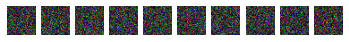

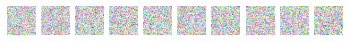

(1000, 32, 32, 3) (1000, 32, 32, 3)


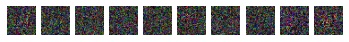

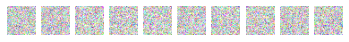

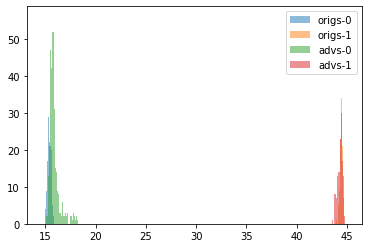

Max perturb norm: 16.0
Wall time: 7min 28s


In [56]:
%%time
IMG_DIM = 32
IMG_CHANNELS = 3
NORM_RANGE_MAX = IMG_DIM * IMG_CHANNELS ** 0.5
ATTACK_EPS = NORM_RANGE_MAX / 2
ATTACK_EPS_STEP = 0.4
ATTACK_ITERS = 40

res = run_experiment(
    image_shape=(IMG_DIM, IMG_DIM, IMG_CHANNELS),
    m1=0.2, s1=0.2,
    m2=0.8, s2=0.2,
    get_model=lambda input_shape: keras.applications.DenseNet121(
        weights=None,
        input_shape=input_shape,
        classes=2,
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=ATTACK_EPS,
    attack_eps_step=ATTACK_EPS_STEP,
    attack_iters=ATTACK_ITERS,
)

count = res["x_test_adv"].shape[0]
origs = (np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(origs[0].shape, origs[1].shape)
plot_images(origs[0][:10])
plot_images(origs[1][:10])
advs = (np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(advs[0].shape, advs[1].shape)
plot_images(advs[0][:10])
plot_images(advs[1][:10])

####

plt.hist(np.linalg.norm(origs[0].reshape((origs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-0")
plt.hist(np.linalg.norm(origs[1].reshape((origs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-1")
plt.hist(np.linalg.norm(advs[0].reshape((advs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-0")
plt.hist(np.linalg.norm(advs[1].reshape((advs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-1")
plt.legend()
plt.show()

print("Max perturb norm:", min(ATTACK_EPS, ATTACK_EPS_STEP * ATTACK_ITERS))